# FollowerAnalyzer Quick Start
In this notebook we demonstrate how to use `FollowerAnalyzer` to compute follower follow times and anomaly scores. We also demonstrate how to create *follower maps* using this package.

## Index
1. Computing follow times and anomaly scores
2. Plot follower maps
3. Using Secim2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import json
from tqdm import tqdm

## 1. Computing follow times and anomaly scores
`FollowerAnalyzer` computes the follow times and anomaly scores for all the followers of a user on social media. The required input is a dictionary that maps the unique follower usernames to two values:
* **rank**: The rank of the follower, starting from 0 for the first follower to N-1 for the last follower, where N is the total number of followers.
* **timestamp**: A timestamp representing the profile creation date of each follower. The timestamp should be in unit of seconds, i.e., seconds from Unix epoch.

Sample dictionary:
```
{
    username1: {"rank": 0, "timestamp": 1512829121}, # First follower
    username1: {"rank": 1, "timestamp": 1464983405}, # Second follower
    ...
}
```

We will use the sample follower data in **sample_data/**

In [2]:
from FollowerAnalyzer.FollowerAnalyzer import FollowerAnalyzer

In [3]:
# Loading sample follower data
path = "sample_data/sample_follower_data.json"
with open(path, "r") as f:
    follower_data = json.load(f)

In [4]:
# Intializing FollowerAnalyzer
# You can optionally pass the profile creation date to improve the follow time predictions for the first few followers
# by filtering out predictions that are before the profile creation date
analyzer = FollowerAnalyzer(follower_data, profile_creation_date=None)

### 1.1 Computing the follow time predictions


In [5]:
# Returns a dictionary that maps follower ids to the predicted follow times
follow_times = analyzer.get_following_times()

### 1.2 Computing anomaly scores
Parameters:
* **n_ranks**: Width of the sliding window, i.e., number of followers to include in each window
* **stride**: Stride, i.e., step of the sliding window
* **creation_date_bins**: Number of bins in the histogram

In [6]:
# Returns a dictionary that maps follower ids to the anomaly scores
anomaly_scores = analyzer.get_anomaly_scores(
    n_ranks=200, stride=40, creation_date_bins=12
)

### 1.3 Getting follower dataframe
The `get_dataframe` method returns a dataframe with the following columns:
* **username**: Follower username
* **rank**: Follower rank, starting from 0 for the oldest follower.
* **timestamp**: Profile creation date of each follower.
* **follow_time**: Estimated follow time, only returned if `include_follow_times` is set to `True`.
* **anomaly_score**: Follower anomaly score, only returned if `include_anomaly_scores` is set to `True`.

In [7]:
# Using the default values for n_ranks, stride, and creation_date_bins
df = analyzer.get_dataframe(
    include_anomaly_scores=True,
    include_follow_times=True,
)

In [8]:
df.head()

,username,rank,timestamp,follow_time,anomaly_score
0,764134597181501441,28853,2016-08-12 13:20:59,2023-01-20 04:27:23,-0.250000
1,1109050397623234560,28852,2019-03-22 08:13:14,2023-01-20 04:27:23,-0.666667
2,357884645,28851,2011-08-18 23:47:21,2023-01-20 04:27:23,2.333333
3,1113910805345574914,28850,2019-04-04 18:06:46,2023-01-20 04:27:23,-0.666667
4,1511660195826606085,28849,2022-04-06 08:01:13,2023-01-20 04:27:23,-0.535714


## 2. Plotting
Using the sample dataset from the previous section, we will demonstrate the plotting functions used to create different versions of a user's follower map. The follower map is a plot that shows all the followers of a user in one graph based on their following rank (x-axis) and their profile creation dates (y-axis). Check the paper for more details.

### 2.1 Follower map (scatter plot) 

In [9]:
from FollowerAnalyzer.Plotting import plot_follower_map

`plot_follower_map` plots a follower map as a scatter plot. Here we use the anomaly score to color the followers, but it could be any other attribute like status count, friend/follower count, etc.

Run the following cell to see all the arguments of `plot_follower_map`

In [ ]:
plot_follower_map?

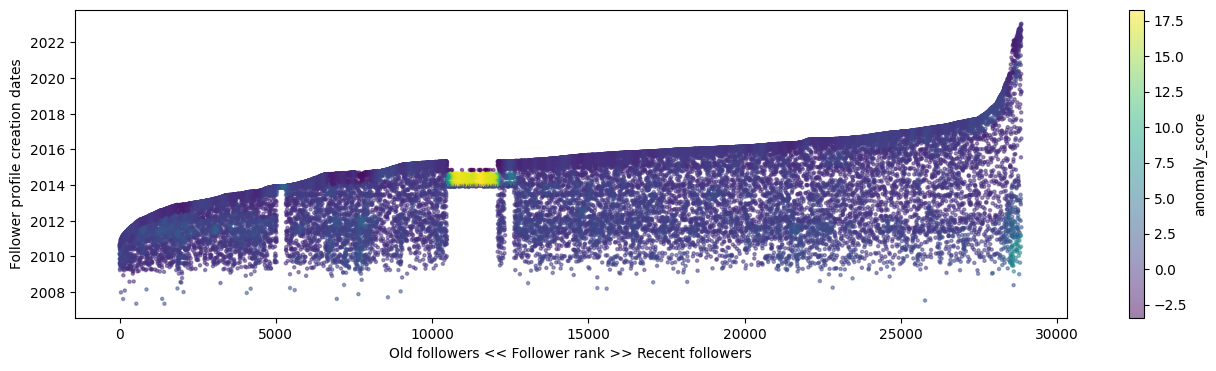

In [10]:
plot_follower_map(df, marker_color="anomaly_score", s=5, zoom=None)
plt.show()

### 2.2 Follower map (heatmap) 

In [11]:
from FollowerAnalyzer.Plotting import plot_follower_heatmap

`plot_follower_heatmap` plots a follower map as a heatmap. This is useful when the number of followers is large that it becomes infeasible to plot a scatter plot. Each heatmap bin represents the followers that fall in that rank/creation date range. The color values are computed as an aggregate function of the followers in each heatmap bin. The aggregation function can be chosen by the user.

Run the following cell to see all the arguments of `plot_follower_heatmap`.

In [ ]:
plot_follower_heatmap?

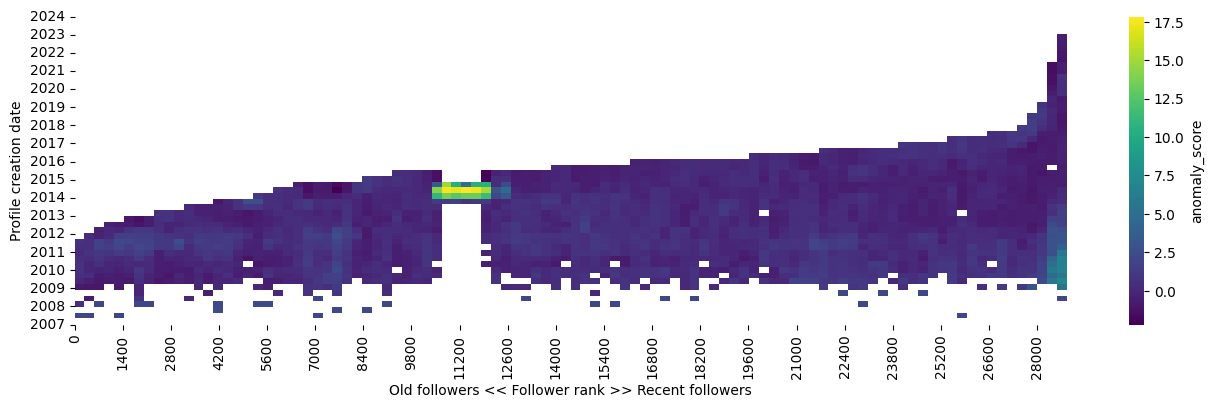

In [13]:
ax = plot_follower_heatmap(
    df, marker_color="anomaly_score", log_scale=False, aggfunc="mean"
)
plt.show()

### 2.3 Detailed view

In [14]:
from FollowerAnalyzer.Plotting import plot_detailed_view

`plot_detailed_view` plots the full follower map, as a scatter plot or heatmap, along with up to three zoomed sub plots showing certain ranges of follower ranks.

Run the following cell to see all the arguments of `plot_detailed_view`.

In [ ]:
plot_detailed_view?

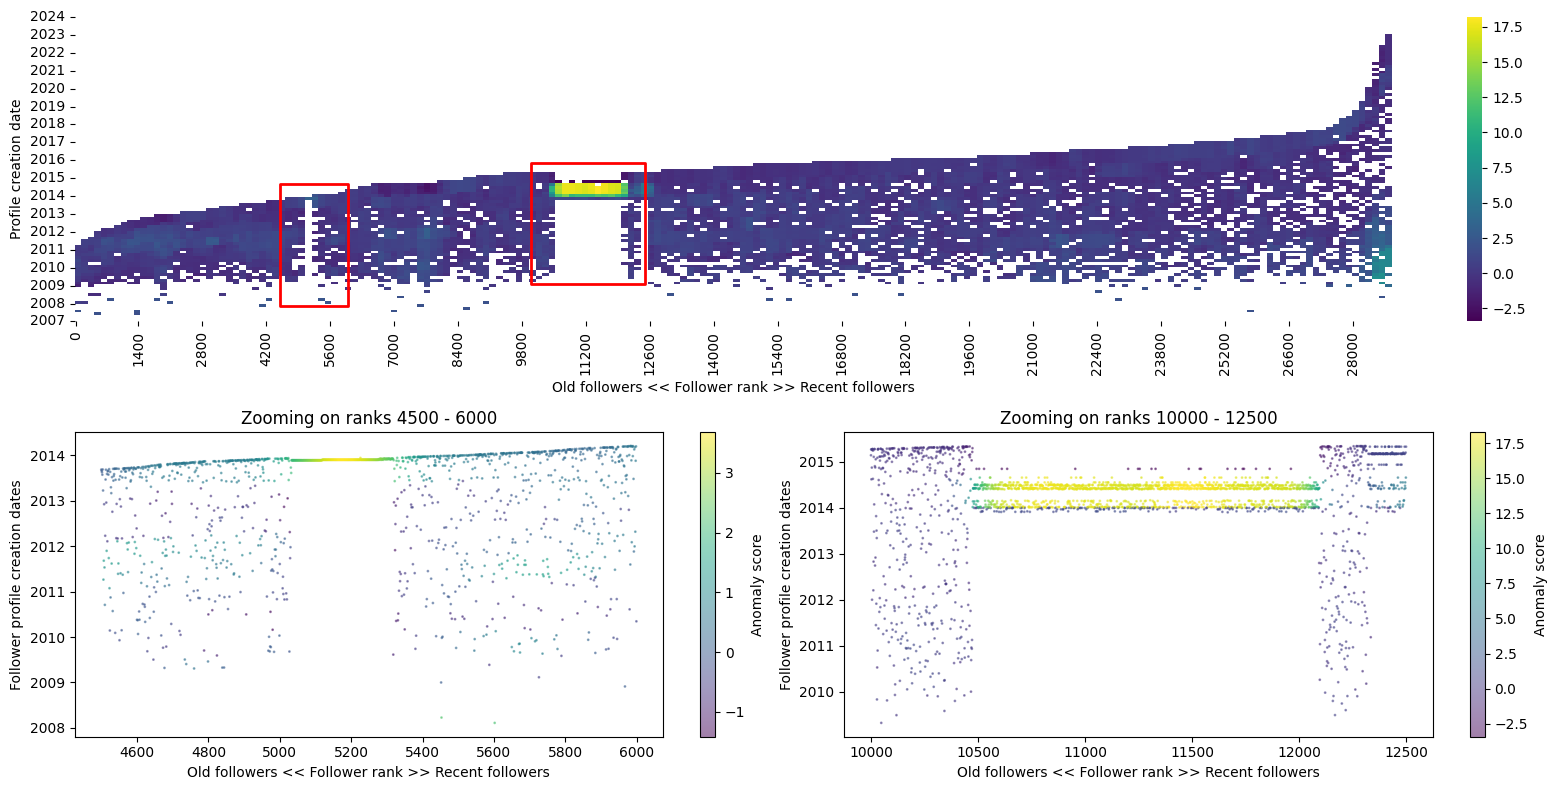

In [15]:
zoom_arr = [(4500, 6000), (10000, 12500)]
plot_detailed_view(df, zoom_arr=zoom_arr, heatmap=True)
plt.show()

## 3. Using Secim2023 data
In this section, we use the data from [Secim2023 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/QJA1ZW) and use it with `FollowerAnalyzer`.

In [16]:
from FollowerAnalyzer.FollowerAnalyzer import FollowerAnalyzer

In [17]:
path = "sample_data/1632532027_network.json.gz"
with gzip.open(path, "rt") as f:
    network_data = json.load(f)

In [18]:
# network_data is a dictionary with keys "friends" and "followers" each having a list of user IDs
# The lists are ordered from most recent to the oldest friend/follower
follower_ids = network_data["followers"]
follower_ids = follower_ids[::-1] # Reversing the list to get the oldest follower first

In [20]:
# We load the follower data to get the follower profile creation dates
# This is a sample from the follower data available in Secim2023
follower_profiles = {}
with gzip.open("sample_data/follower_profiles_sample.jsons.gz", mode="rt") as f:
    for line in tqdm(f):
        profile = json.loads(line)
        follower_id = profile["id_str"]
        follower_profiles[follower_id] = profile

49191it [00:00, 105549.70it/s]


Creating follower data dictionary to pass to `FollowerAnalyzer`

In [21]:
follower_data = {}
rank = 0
missing_follower_ids = []
for follower_id in tqdm(follower_ids):
    profile = follower_profiles.get(
        follower_id, None
    )  # Some follower data may not exist
    if profile is not None:
        timestamp = profile["timestamp"]

        # Filtering out followers that followed before 2006
        # Some follower timestamps are incorrect (mostly = 0)
        if timestamp < pd.Timestamp('2006-01-01').timestamp():
            continue

        # Adding extra data from the follower profile
        statuses_count = profile["statuses_count"]
        followers_count = profile["followers_count"]
        friends_count = profile["friends_count"]
        follower_data[follower_id] = {
            "rank": rank,
            "timestamp": timestamp,
            "statuses_count": statuses_count,
            "followers_count": followers_count,
            "friends_count": friends_count,
            }
        rank += 1
    else:
        missing_follower_ids.append(follower_id)

print(f"Number of missing followers: {len(missing_follower_ids)}")

100%|██████████| 16265/16265 [00:00<00:00, 234492.23it/s]

Number of missing followers: 23


In [22]:
# Computing follow times and anomaly scores
follower_analyzer = FollowerAnalyzer(follower_data, profile_creation_date=None)
df = follower_analyzer.get_dataframe(
    include_follow_times=True, include_anomaly_scores=True
)

# Adding the extra information from the follower profiles
for col in ["statuses_count", "followers_count", "friends_count"]:
    df[col] = df["username"].map(lambda x: follower_profiles[x][col])

In [23]:
from FollowerAnalyzer.Plotting import plot_follower_map, plot_follower_heatmap

The following follower map shows a user with anomalous followers. The number of shared statuses by the group of anomalous followers is clearly lower than the remaining followers.

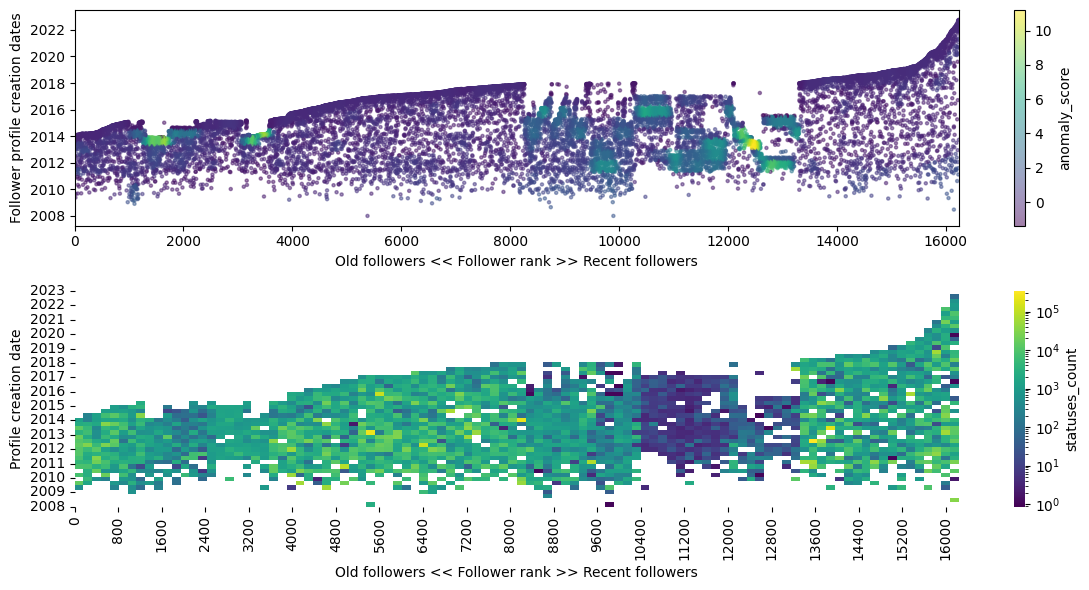

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), tight_layout=True)
plot_follower_map(df, ax=axs[0], marker_color="anomaly_score", s=5)
axs[0].set_xlim(0, df["rank"].max())
plot_follower_heatmap(df, ax=axs[1], marker_color="statuses_count", log_scale=True, aggfunc="mean")
plt.show()